# A Local Static Map - Visualizing PPGIS Data from Helsinki

In this tutorial, we will work with a PPGIS dataset from Helsinki and explore methods to create a local map of our data. Public Participation Geographic Information Systems (PPGIS) blend GIS technologies with public participation processes for a more inclusive approach to spatial planning and policymaking. PPGIS utilizes map-based surveys and geospatial tools to gather public feedback on projects like urban development, environmental conservation, and transportation planning. Its key focus is enabling communities to contribute directly to the planning process, ensuring decisions are democratic, equitable, and informed. Learn more about PPGIS [here](https://en.wikipedia.org/wiki/Participatory_GIS).

We're using an open, anonymized dataset from the Zenodo [repository](https://zenodo.org/records/3621342), collected as part of the Urban Happiness project at Aalto University. It includes datasets on home locations, everyday errands, and experience points in Helsinki and Espoo. This tutorial focuses on Helsinki's experiential data, representing places marked by participants. We're particularly interested in the `Quality` column, which indicates whether places are perceived as *Positive* or *Negative*.

Throughout this tutorial, we'll create various visualizations using vector data, practicing:

- Basic point maps
- Adding basemaps to static maps
- Manipulating and classifying data to enhance maps
- Visualizing large point datasets to identify patterns
- Working with map legends
- Adding custom symbols and labels to maps
- Creating kernel density estimate maps

We'll explore different Python libraries, each with unique strengths in handling and visualizing geospatial data:

- **Numpy**: Essential for scientific computing and handling arrays. [Numpy Documentation](https://numpy.org/doc/)
- **Pandas**: Provides high-performance data structures and analysis tools. [Pandas Documentation](https://pandas.pydata.org/pandas-docs/stable/)
- **Osmnx**: Facilitates the download and analysis of street networks from OpenStreetMap. [Osmnx Documentation](https://osmnx.readthedocs.io/en/stable/)
- **Geopandas**: Extends pandas for geospatial data operations. [Geopandas Documentation](https://geopandas.org/en/stable/)
- **Matplotlib**: Our primary tool for static, interactive, and animated visualizations. [Matplotlib Documentation](https://matplotlib.org/contents.html)
- **Contextily**: Adds basemaps to matplotlib figures. [Contextily Documentation](https://contextily.readthedocs.io/en/latest/)
- **TileMapBase**: Yet another library for adding basemaps to our map. [TileMapBase Documentation](https://github.com/MatthewDaws/TileMapBase).
- **Seaborn**: Offers a higher-level interface for attractive statistical graphics, built on Matplotlib. [Seaborn Documentation](https://seaborn.pydata.org/)

By the end of this tutorial, you'll have the skills to create static visualizations of local geospatial data and uncover insights from datasets. Let's get started!


## Data exploration

We start by importing and exploring our data using Geopandas library.

      uid   Qual_Type   Quality                        geometry
0  910016  Functional  negative  POINT (383963.576 6678744.481)
1  910027  Functional  negative  POINT (383556.242 6678875.531)
2  910032  Functional  negative  POINT (376916.069 6690259.731)
3  910040  Functional  negative  POINT (383559.950 6678939.785)
4  910045  Functional  negative  POINT (383628.949 6678098.600)


<Axes: >

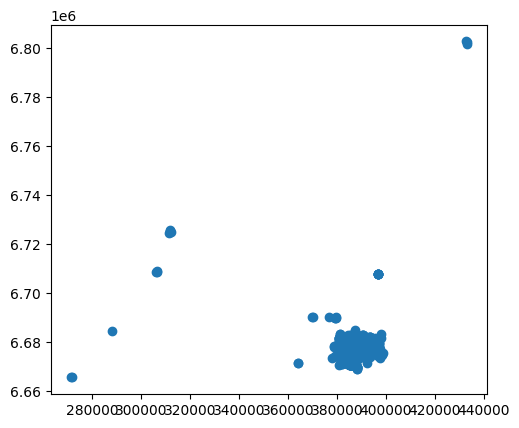

In [1]:
import geopandas as gpd

# Path to our Experience data from Helsinki
file_path = 'data/PPGIS/ExperiencePoints_All_Helsinki.shp'

# read the data as a geodataframe named exp_places
exp_places = gpd.read_file(file_path)
print(exp_places.head())
exp_places.plot()

We have several outlier points that fall well outside our study area, which is Helsinki. These outliers are not only irrelevant to our study (being outside our area of interest) but can also negatively affect the appearance of our map. Therefore, it's important to exclude them.

The simplest method to achieve this is by using a polygon that defines our study area. In our case, the Helsinki polygon can be sourced from a variety of places. For our purposes, we will utilize the `osmnx` library to obtain the official boundary of Helsinki from [OpenStreetMap (OSM)](https://www.openstreetmap.org/) and convert it into a GeoDataFrame (GDF).

Let's proceed to fetch the Helsinki polygon.

<Axes: >

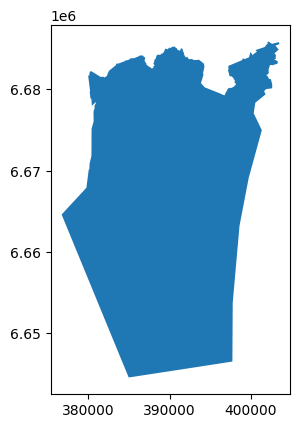

In [2]:
# Import the needed library
import osmnx

PLACE_NAME = "Helsinki, Finland"
hel_area = osmnx.geocode_to_gdf(PLACE_NAME)

# Get the polygon to the same CRS as original data (this is important as we are going to perform a spatial join)
hel_area = hel_area.to_crs(exp_places.crs)
hel_area.plot()

Now, we will perform a spatial join using the `inner` method to retain only the points that fall `within` the Helsinki polygon. It's crucial in spatial join operations to ensure that all data layers share the same Coordinate Reference System (CRS). Although we projected our polygon in the previous step, it's good practice to start with an `assert` statement to double-check the CRS alignment.

This precaution helps prevent common errors in spatial analysis, ensuring our join operation accurately matches points to the Helsinki area based on their geographical location.


In [3]:
assert exp_places.crs == hel_area.crs, "CRS do not match"

If the assertion passes without errors, we're all set to proceed with our spatial join. Should you need a refresher on how to perform a **Spatial Join** using Geopandas, remember to check the [AutoGIS course page](https://autogis-site.readthedocs.io/en/latest/lessons/lesson-3/spatial-join.html). This resource provides detailed instructions and examples to guide you through the process, ensuring you can confidently apply spatial joins to your data.


In [4]:
# Do the spatial join and extract the points which are within the polygon
points_in_helsinki = gpd.sjoin(exp_places, hel_area, how="inner", predicate='within')

## 1. Point map

To enhance the context of our geospatial data, adding a basemap can be incredibly helpful. While basemaps are not always necessary for every type of map, they can significantly aid in contextualizing our data, making it easier for viewers to understand the geographical placement and surroundings of the data points. The Python library `Contextily` simplifies the process of adding a basemap to our maps created with Matplotlib. You can read more about the library and explore a list of available basemap providers [here](https://contextily.readthedocs.io/en/latest/providers_deepdive.html). Additionally, to learn how to effectively use this library, the [AutoGIS course page](https://autogis-site.readthedocs.io/en/latest/lessons/lesson-5/static-maps.html) offers detailed guidance and examples.

Remember that when you are working with interenet map contents, the basemap in our case, you have to have your other layers in a compatible CRS. Hence we are projecting our data to `EPSG:3857` .

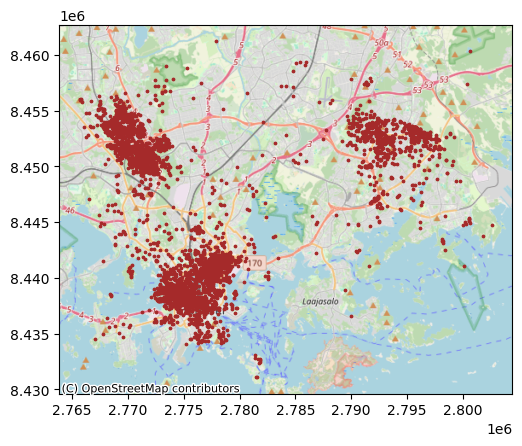

In [5]:
import contextily
points_to_vis = points_in_helsinki.to_crs("EPSG:3857")
ax= points_to_vis.plot(markersize=3, color='brown')
contextily.add_basemap(ax, source=contextily.providers.OpenStreetMap.Mapnik)

Ensuring the integrity and accuracy of our data is a pivotal step towards creating informative and visually appealing maps. A critical part of this process involves closely examining the data we plan to visualize, particularly focusing on key attributes that will drive our analysis and presentation. One such attribute is the "Quality" column within our dataset. It's essential to scrutinize the range of values this column contains, as it directly influences how we interpret and represent our geospatial data on the map. Let's take a moment to review the values in the "Quality" column to confirm their accuracy and consistency, ensuring they align with our mapping objectives.

In [6]:
points_in_helsinki.Quality.unique()

array(['negative', 'Positive', 'Negative'], dtype=object)

Our thorough examination has paid off, revealing that the "Negative" values in the "Quality" column have inconsistent capitalization, appearing as both "negative" and "Negative." This variance, if left unaddressed, could skew our map's accuracy. Let's rectify this by standardizing the capitalization, ensuring our data's consistency and reliability for accurate mapping.

In [7]:
points_in_helsinki['Quality'] = points_in_helsinki['Quality'].replace('negative', 'Negative')

Now, we're set to refine our map with several key enhancements. In this updated version, we'll incorporate a superior basemap that complements our data's visual narrative. Additionally, we'll streamline the map's appearance by removing axis ticks and labels, creating a cleaner and more focused presentation. Finally, we'll introduce color coding for the points based on the "Quality" value, adding an intuitive layer of analysis that allows viewers to distinguish between positive and negative locations. 

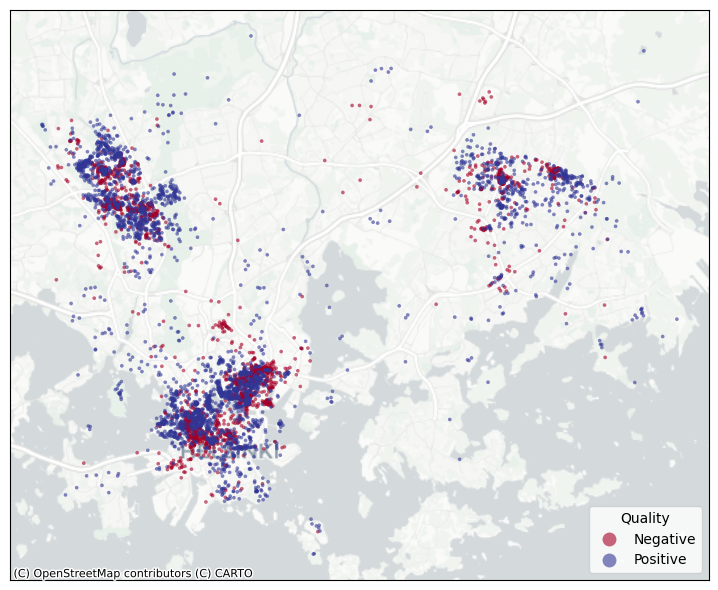

In [8]:
# Convert to Web Mercator
points_to_vis = points_in_helsinki.to_crs("EPSG:3857")

# Plotting with colors based on the 'Quality' column. 
ax = points_to_vis.plot(markersize=7, column='Quality', cmap='RdYlBu', legend=True, alpha = 0.6, edgecolor='none', legend_kwds={"title": "Quality", "loc" : "lower right"})

# Adding a basemap
contextily.add_basemap(ax, source=contextily.providers.CartoDB.Positron)

# Remove ticks and axis labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

# Optionally, if you want to remove the axis entirely including the box around the plot, you can use:
ax.axis('on')
# Adjust figure size to accommodate the legend, if necessary
fig = ax.figure
fig.set_size_inches(8, 6)
fig.tight_layout()



We now have a visually appealing point map. However, with datasets characterized by dense clusters of points where negative and positive locations often overlap, the effectiveness of point maps can be somewhat questionable. Recognizing this challenge, we'll explore alternative visualization techniques in our next steps. Our goal is to enhance the representation of this PPGIS data, exploring different cartographic methods that might better convey the spatial patterns and relationships inherent in our dataset. **Rememebr our aims**: to uncover more **insightful** and **user-friendly** ways to visualize complex spatial data.


## A grid-based representation

One effective strategy to address the challenge of overlapping and densely clustered points is by aggregating our points into larger areas. While this can often involve grouping points by real-world boundaries, such as neighborhoods, to provide a localized analysis of experiences, our current focus is on a broader view of Helsinki rather than its specific neighborhoods. To achieve this, we can construct a grid network that encompasses all our points. By aggregating our points into these grid cells, we can perform calculations that serve as the basis for our visualization. This approach allows us to transform a complex mass of individual data points into a clear, coherent picture of overall trends and patterns across the city, offering an innovative way to represent large point data.

Let's create the grid:

In [9]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, Point
import numpy as np

# Assuming 'points_gdf' is your points GeoDataFrame

# Determine the bounds of your point data
minx, miny, maxx, maxy = points_in_helsinki.total_bounds

# Grid dimensions
grid_height = 250
grid_width = 250

# Generate the x and y coordinates for the grid
x_coords = np.arange(minx, maxx + grid_width, grid_width)
y_coords = np.arange(miny, maxy + grid_height, grid_height)

# Initialize a list to hold the grid polygons
grid_polygons = []

for x in x_coords:
    for y in y_coords:
        # Define the polygon for each cell
        polygon = Polygon([(x, y), (x+grid_width, y), (x+grid_width, y+grid_height), (x, y+grid_height)])
        grid_polygons.append(polygon)

# Create a GeoDataFrame from the grid polygons
grid = gpd.GeoDataFrame({'geometry': grid_polygons}, crs=points_in_helsinki.crs)


Having previously performed a spatial join on our data, we now find ourselves with duplicate fields, namely `index_right` and `index_right`, which may lead to errors in subsequent analyses. Although one solution is to configure the spatial join (`sjoin`) to assign alternative names to these columns, a more straightforward approach is simply to remove them. Since these columns are not required for our ongoing work, dropping them from our dataset not only simplifies our data structure but also eliminates any potential for confusion or error moving forward.

In [10]:
#print(points_in_helsinki.columns)
try:
    points_in_helsinki = points_in_helsinki.drop(columns=['index_right'])
except:
    print("No such columns")

#print(grid.columns)
try:
    grid = grid.drop(columns=['index_left'])
except:
    print("No such columns")

No such columns


Now we do the spatial join:

In [11]:
import geopandas as gpd
import pandas as pd

# Perform the spatial join
joined_gdf = gpd.sjoin(grid, points_in_helsinki, how="inner", predicate='contains')

# Group by the grid cell index (left_index from the spatial join) and count positive and negative points
count_df = joined_gdf.groupby(joined_gdf.index)['Quality'].apply(lambda x: x.value_counts()).unstack()

# Fill NaN values with 0 (for cells that might have only positive or only negative points, or none)
count_df = count_df.fillna(0).astype(int)

count_df.head()

Negative  Positive
43         0         1
45         0         1
48         0         1
50         0         4
69         0         1

<Axes: >

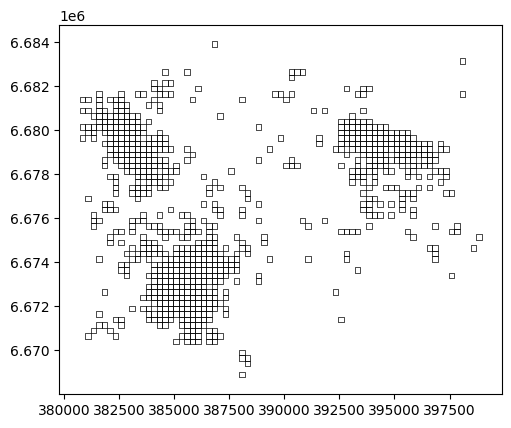

In [12]:
# Filter out grid cells that do not contain any point (both pos_cnt and neg_cnt are 0)
count_df = count_df[(count_df['Negative'] > 0) | (count_df['Positive'] > 0)]

# Join the counts back to the original grid GeoDataFrame using the grid index
# Only include grid cells that have counts (i.e., at least one point)
grid_with_counts = grid.join(count_df, how='inner')

# Plot the grid
grid_with_counts.plot(edgecolor='black', facecolor='none', linewidth=0.5)

To further refine our analysis and visualization, we aim to transform the raw counts of positive and negative points per cell into a more interpretable and visually accessible metric. An effective strategy for achieving this is the calculation of a "positivity score." This score quantifies the overall sentiment of each cell on a scale where:

- A score close to 1 signifies a predominantly positive sentiment,
- A score close to -1 denotes a predominantly negative sentiment, and
- A score around 0 reflects a neutral or balanced sentiment, indicating an equal distribution of positive and negative values.

The formula for calculating the positivity score is as follows:

$$
\text{Positivity Score} = \frac{\text{Positive} - \text{Negative}}{\text{Positive} + \text{Negative}}
$$

By integrating this score into our visualization, we can offer a nuanced view of the spatial distribution of sentiments, enhancing the overall utility and insightfulness of our PPGIS data representation. But **remember** that this is just one way to analyze and visualize our data. Depending on what you're looking at, the kind of data you have, and the map you're working with, there could be many different methods that might work better. This approach gives us a straightforward way to get a quick sense of the overall sentiment in each area. 

In [13]:
import numpy as np

# Calculate the positivity score
grid_with_counts['Positivity_Score'] = (grid_with_counts['Positive'] - grid_with_counts['Negative']) / (grid_with_counts['Positive'] + grid_with_counts['Negative']).replace({0: np.nan})

# Handle cases where the denominator was 0 by replacing NaN with 0 or another suitable value
grid_with_counts['Positivity_Score'] = grid_with_counts['Positivity_Score'].fillna(0)

# Now, 'gdf' includes a 'Positivity_Score' column with values ranging from -1 to 1
grid_with_counts.head(10)

geometry  Negative  Positive  \
43   POLYGON ((380707.626 6679515.283, 380957.626 6...         0         1   
45   POLYGON ((380707.626 6680015.283, 380957.626 6...         0         1   
48   POLYGON ((380707.626 6680765.283, 380957.626 6...         0         1   
50   POLYGON ((380707.626 6681265.283, 380957.626 6...         0         4   
69   POLYGON ((380957.626 6670515.283, 381207.626 6...         0         1   
94   POLYGON ((380957.626 6676765.283, 381207.626 6...         1         0   
106  POLYGON ((380957.626 6679765.283, 381207.626 6...         0         1   
107  POLYGON ((380957.626 6680015.283, 381207.626 6...         2         0   
110  POLYGON ((380957.626 6680765.283, 381207.626 6...         0         1   
112  POLYGON ((380957.626 6681265.283, 381207.626 6...         1         0   

     Positivity_Score  
43                1.0  
45                1.0  
48                1.0  
50                1.0  
69                1.0  
94               -1.0  
106               1.0  
107              -1.0  
110               1.0  
112              -1.0

Let's make a quick visualization of the values we just calculated: 

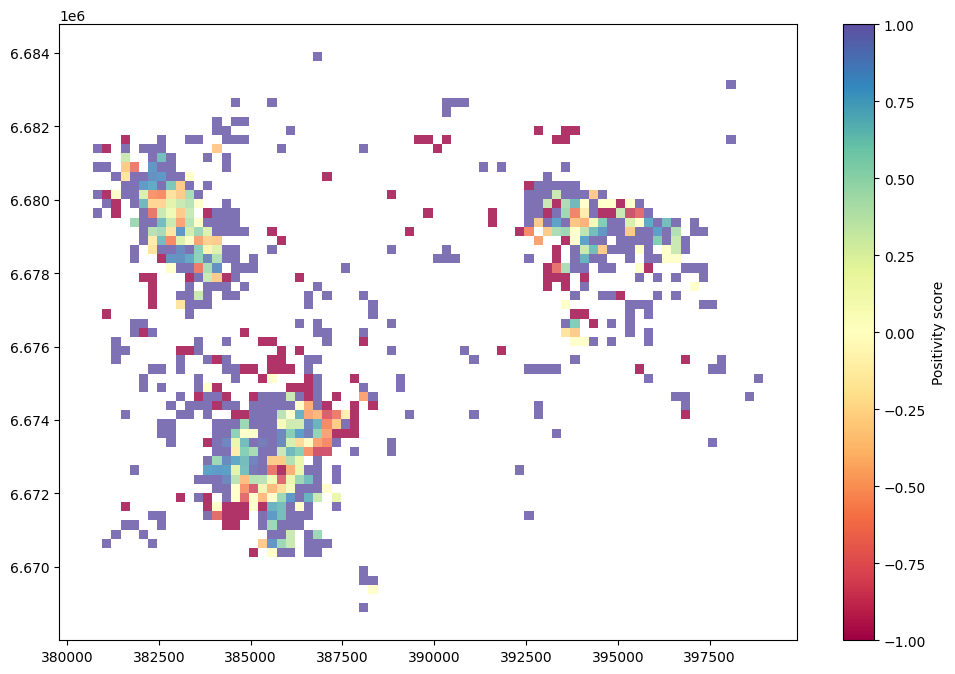

In [14]:
ax = grid_with_counts.plot(
    figsize=(12, 8),

    column="Positivity_Score",
    cmap="Spectral",
    linewidth=0,
    alpha=0.8,

    legend=True,
    legend_kwds={"label": "Positivity score"}
)

The detailed granularity of values in our map can overwhelm the viewer, making it difficult to discern meaningful patterns. To enhance interpretability, we'll simplify our data classification by adopting the [Natural Breaks method](https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization), also known as Jenks optimization. This approach will group our data into categories based on natural groupings inherent in the data, reducing complexity and focusing on significant distinctions between values. With this reclassification, we'll generate a new, clearer map that better communicates the underlying spatial trends.

<Axes: >

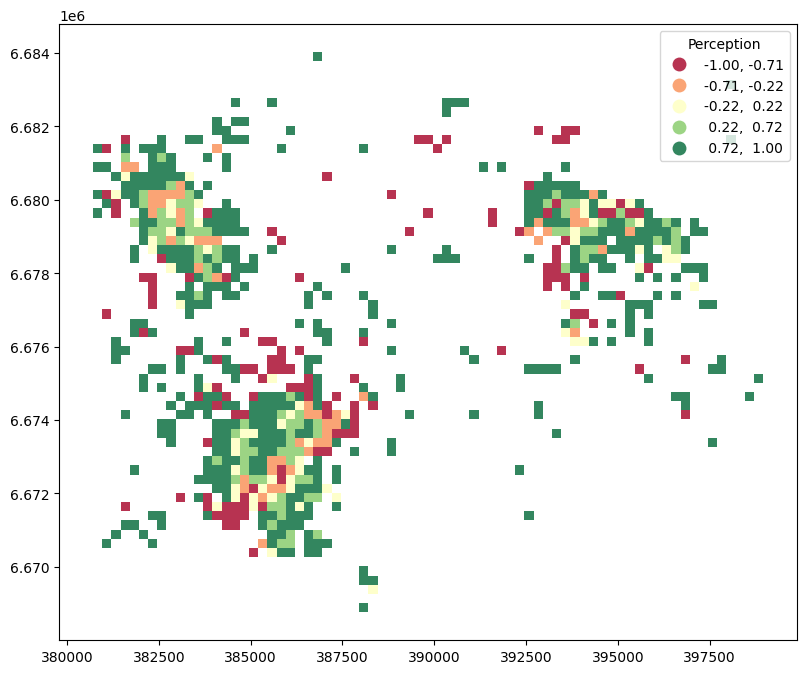

In [15]:
grid_with_counts.plot(
    figsize=(12, 8),

    column="Positivity_Score",
    scheme="NaturalBreaks",
    cmap="RdYlGn",
    linewidth=0,
    alpha=0.8,

    legend=True,
    legend_kwds={"title": "Perception"}
)

Let's enhance the visual appeal of our map to make it more accessible and aesthetically pleasing. Recognizing that a red and green color scheme is not ideal for individuals with color blindness, we'll select a different color palette that is more inclusive. Additionally, we'll incorporate a basemap to provide context and depth to our visualization. To ensure clarity, we'll position the legend carefully to avoid obscuring any important map details. We'll also adjust the transparency of our overlaying layers, achieving a balanced visual composition that allows for easy interpretation of the map's contents.

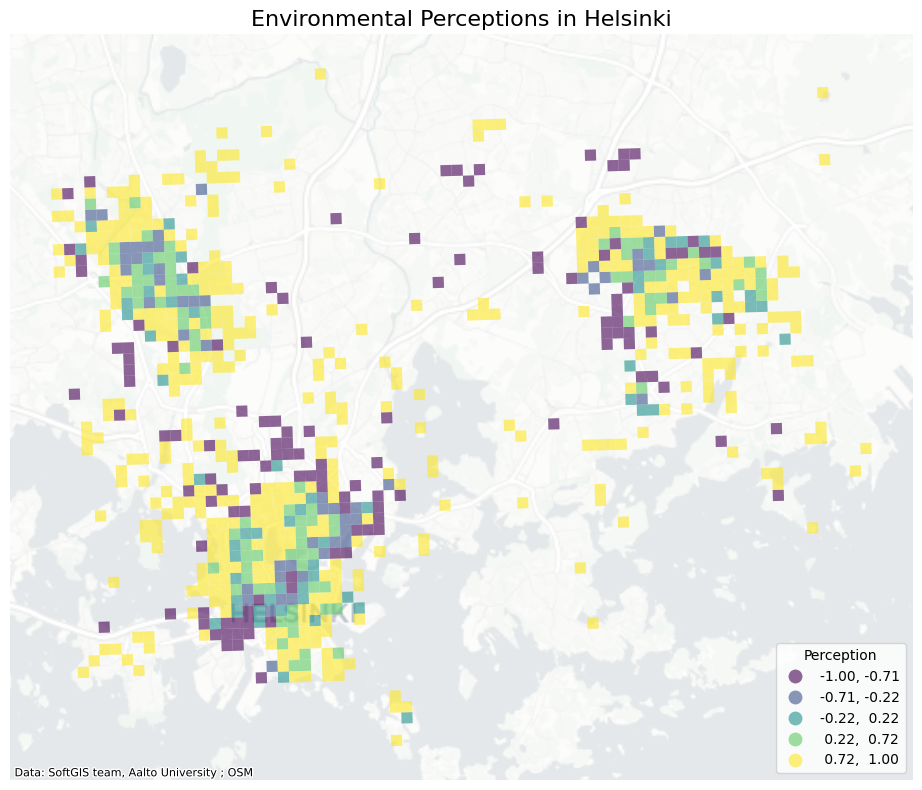

In [16]:
import contextily
import matplotlib.pyplot as plt
grid_with_counts = grid_with_counts.to_crs("EPSG:3857")
ax = grid_with_counts.plot(
    figsize=(12, 8),

    column="Positivity_Score",
    scheme="NaturalBreaks",
    cmap="viridis",
    linewidth=0,
    alpha=0.6,

    legend=True,
    legend_kwds={"title": "Perception", "loc": "lower right"}
)

# Remove axis
ax.set_axis_off()
plt.title('Environmental Perceptions in Helsinki', fontdict={'fontsize': '16', 'fontweight' : '3'})
contextily.add_basemap(
    ax,
    source=contextily.providers.CartoDB.Positron,alpha=0.6,
    attribution=("Data: SoftGIS team, Aalto University ; OSM")
)
plt.tight_layout()
plt.show()

### Adding landmarks: custom symbols and labels

To make our map more user-friendly and easier to navigate, incorporating landmarks can significantly enhance spatial orientation. By highlighting well-known places, users can quickly identify specific areas of interest within Helsinki. While we'll manually add a few landmarks using their coordinates for demonstration purposes, it's worth noting that such data can also be sourced from platforms like OpenStreetMap (OSM). As a first step, we'll create GeoDataFrames for these landmarks, setting the stage for a more informative and navigable map visualization.

In [17]:
landmarks_dict = {
    'Helsinki White Church': (60.1695, 24.9514),
    'Pasila Railway Station': (60.1989, 24.9332),  # Added Pasila Railway Station with its coordinates
    'Itis': (60.2106, 25.0832)
}

# Create a GeoDataFrame
landmarks = gpd.GeoDataFrame({
    'name': landmarks_dict.keys(),
    'geometry': [Point(xy[::-1]) for xy in landmarks_dict.values()]  # Note the reversed order for Point(lon, lat)
})

# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
landmarks.set_crs(epsg=4326, inplace=True)

name                   geometry
0   Helsinki White Church  POINT (24.95140 60.16950)
1  Pasila Railway Station  POINT (24.93320 60.19890)
2                    Itis  POINT (25.08320 60.21060)

We will now integrate the landmarks using custom symbols, such as specific images that represent each landmark. This visual enhancement not only adds an element of realism but also makes the map more engaging and recognizable. Alongside these symbols, we'll include labels for each landmark to ensure users can easily identify these notable places. This combination of custom imagery and clear labeling can enhance the user's ability to navigate and understand the spatial layout of Helsinki within our map. Specially if they are not very familiar with the area.

Initially, we'll introduce the landmarks onto the map using start symbols. Following this, we'll further personalize the visualization by incorporating custom images for each landmark. 

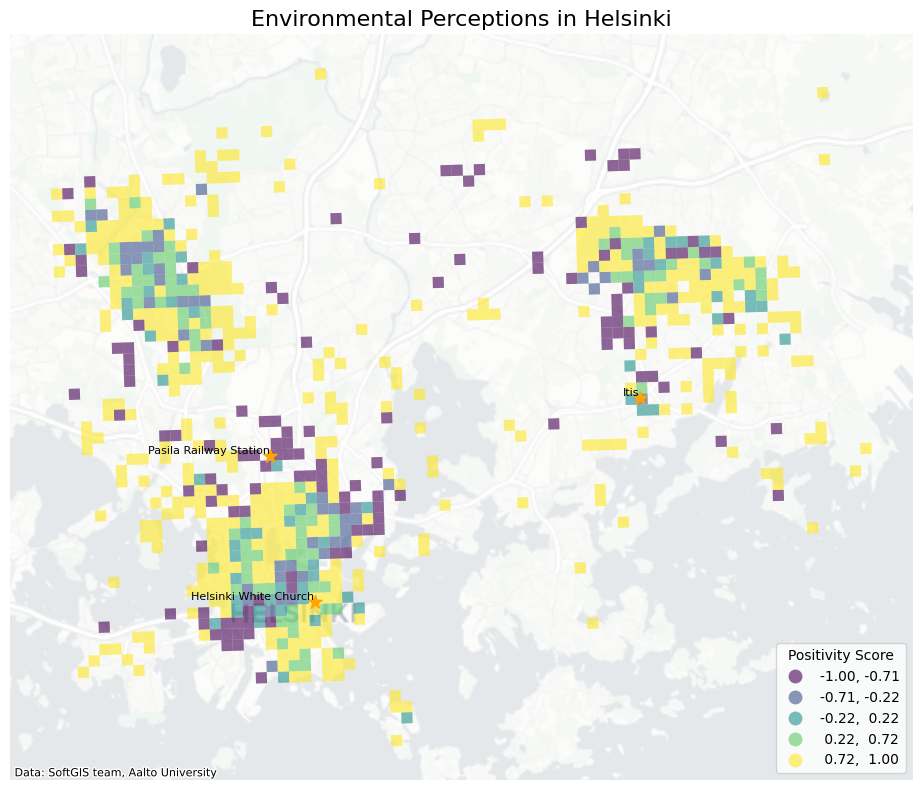

In [18]:
import contextily
import matplotlib.pyplot as plt

ax = grid_with_counts.plot(
    figsize=(12, 8),
    column="Positivity_Score",
    scheme="NaturalBreaks",
    cmap="viridis",
    linewidth=0,
    alpha=0.6,
    legend=True,
    legend_kwds={"title": "Positivity Score", "loc": "lower right"}
)

# Convert landmarks to the same CRS
landmarks = landmarks.to_crs("EPSG:3857")

# Plot landmarks as stars on the map
landmarks.plot(ax=ax, marker='*', color='orange', markersize=100, label='Landmarks')

# Label landmarks using the 'name' column
for x, y, label in zip(landmarks.geometry.x, landmarks.geometry.y, landmarks['name']):
    ax.text(x, y, label, fontsize=8, ha='right', va='bottom')

# Remove axis
ax.set_axis_off()

# Set title
plt.title('Environmental Perceptions in Helsinki', fontdict={'fontsize': '16', 'fontweight': '3'})

# Add basemap
contextily.add_basemap(
    ax,
    source=contextily.providers.CartoDB.Positron,
    alpha=0.6,
    attribution=("Data: SoftGIS team, Aalto University")
)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


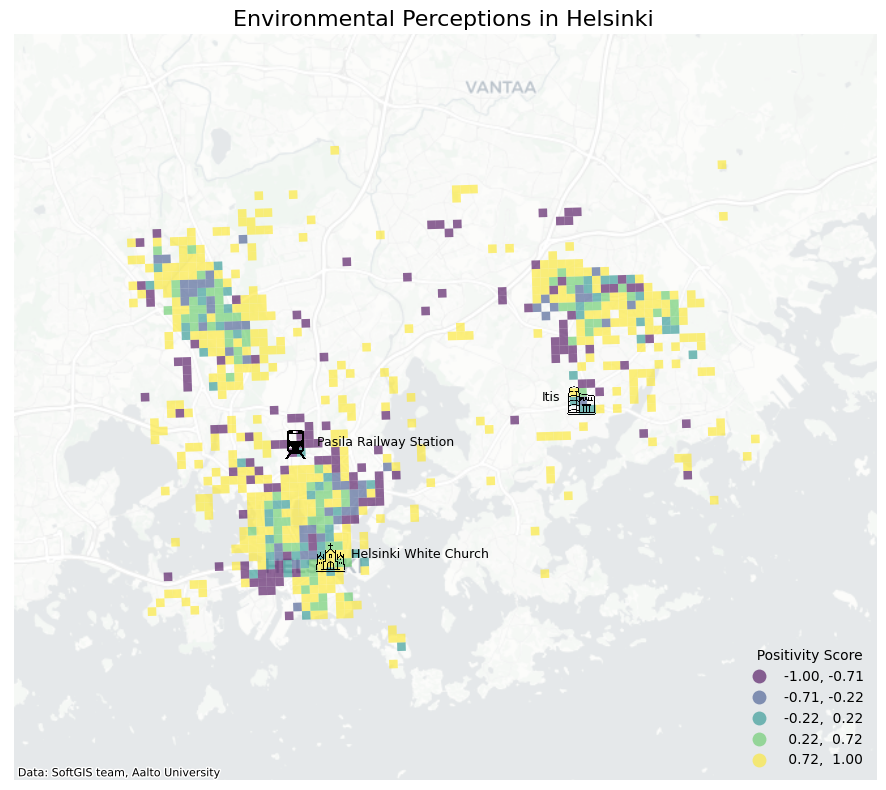

In [19]:
import contextily
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Function to add an image at a given location on the map
def add_image_at_location(ax, filepath, coord, zoom):
    img = plt.imread(filepath)
    imagebox = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(imagebox, coord, frameon=False, bboxprops=dict(edgecolor='none'))
    ax.add_artist(ab)

ax = grid_with_counts.plot(
    figsize=(12, 8),
    column="Positivity_Score",
    scheme="NaturalBreaks",
    cmap="viridis",
    linewidth=0,
    alpha=0.6,
    legend=True,
    legend_kwds={"title": "  Positivity Score", "loc": "lower right", "frameon" : False,"fancybox" : False}
)

# Convert landmarks to the same CRS
landmarks = landmarks.to_crs("EPSG:3857")

# Custom icons for each landmark
icons = {
    'Itis': "assets/icons/shop.png",
    'Helsinki White Church': "assets/icons/church.png",
    'Pasila Railway Station': "assets/icons/train.png"
}

# Plot each landmark with its custom icon
for _, row in landmarks.iterrows():
    x, y = row.geometry.x, row.geometry.y
    name = row['name']
    if name in icons:
        add_image_at_location(ax, icons[name], (x, y), zoom=0.04)
        if name != "Itis":
            ax.text(x + 9300, y - 200, name, fontsize=9, ha='right', va='bottom')
        else:
            ax.text(x -1200, y - 200, name, fontsize=9, ha='right', va='bottom')
    else:
        # Plot with a default marker if no icon is specified
        ax.plot(x, y, marker='*', color='orange', markersize=10, label='Landmarks')
        ax.text(x, y, name, fontsize=8, ha='right', va='bottom')

# Remove axis
ax.set_axis_off()

# Set title
plt.title('Environmental Perceptions in Helsinki', fontdict={'fontsize': '16', 'fontweight': '3'})

# Add basemap
contextily.add_basemap(
    ax,
    source=contextily.providers.CartoDB.Positron,
    alpha=0.6,
    attribution=(" Data: SoftGIS team, Aalto University")
)

# Adjust the view to zoom out a bit
ax.set_xlim(ax.get_xlim()[0] - 5000, ax.get_xlim()[1] + 5000)
ax.set_ylim(ax.get_ylim()[0] - 5000, ax.get_ylim()[1] + 5000)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## Kernel density map
A kernel density map, or a heat map, visualizes the density of data points across a geographical area, smoothing them over a surface to indicate concentrations. This method can be useful for our dataset, where positive and negative points frequently overlap, making it challenging to distinguish patterns with traditional point maps. By applying [kernel density estimation (KDE)](https://en.wikipedia.org/wiki/Kernel_density_estimation), we can transform these overlapping points into a continuous density surface, highlighting areas with high concentrations of either positive or negative feedback. This approach allows for a more nuanced understanding of spatial trends and can reveal underlying patterns that are not immediately apparent from the raw data.

For this part of our tutorial we will work with two new libraries:
- TileMapBase: Another library for adding basemaps to our maps
- Seaborn: A higher-level library based on Matplotlib for creating attractive statistical graphics and maps

`TileMapBase` and `Contextily` are both Python libraries designed to enhance geospatial visualizations by adding basemaps to plots, but they serve this purpose in slightly different ways and contexts. `TileMapBase` offers a flexible, if somewhat manual, approach to map tile integration, suitable for a variety of visualization needs. `Contextily`, on the other hand, focuses on ease of use and integration with geospatial data, making it a go-to for quickly adding rich, contextual backgrounds to static maps. The choice between them depends on your specific project requirements, preferred workflow, and the level of customization you need.

Creating similar maps as part of a repetitive process (e.g., generating separate kernel density maps for place experiences in each neighborhood of Helsinki), benefits greatly from writing your code in a modular fashion. By encapsulating parts of the map creation process that are repeatable into functions, you streamline the workflow, making it more efficient to produce similar maps. For instance, the code in the cell below demonstrates how segmenting the mapping process into a callable function can simplify generating these maps with varied inputs by merely executing the function with different parameters.

In [35]:
import tilemapbase
tilemapbase.init(create=True)
import seaborn as sns
import matplotlib.pyplot as plt

def plot_map(fig, ax, points_plot, polygons_plot, file_name, extent, leg):
    """
    A short helper function that takes points and polygons as input
    and creates a plot with a basemap.
    """
    # Assuming extent and bounding_box are predefined or calculated elsewhere
    #plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=1000)
    plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.Carto_Light, width=1000)
    # To hide the ticks, you can set the tick labels to an empty list for both axes
    ax.set_xticks([])
    ax.set_yticks([])

    # If you also want to hide the axis labels (not just the ticks), you can do:
    ax.set_xlabel('')
    ax.set_ylabel('')
    plotter.plot(ax)
    if leg:
        # Create and add a color bar
        norm = plt.Normalize(vmin=density_plot.collections[0].get_array().min(), vmax=density_plot.collections[0].get_array().max())
        sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
        sm.set_array([])
        # Create colorbar
        cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.07)
        # Remove colorbar ticks
        cbar.set_ticks([])
        # Label 'Higher density' at the top and 'Lower density' at the bottom of the colorbar
        cbar.set_label('Density', rotation=270, labelpad=15)
        cbar.ax.text(0.5, 1.05, 'Higher density', ha='center', va='bottom', transform=cbar.ax.transAxes)
        cbar.ax.text(0.5, -0.05, 'Lower density', ha='center', va='top', transform=cbar.ax.transAxes)


    # Assuming polygons_plot and points_plot are GeoDataFrames or similar objects
    # that need to be plotted on the ax. 
    if polygons_plot is not None:
        polygons_plot.plot(ax=ax, edgecolor='red', facecolor='none')  # Customize as needed

    if points_plot is not None:
        points_plot.plot(ax=ax, marker='o', color='blue', markersize=5)  # Customize as needed

    # Save the figure
    if file_name is not None:
        fig.savefig(f'./saved_maps/{file_name}.png', bbox_inches='tight')


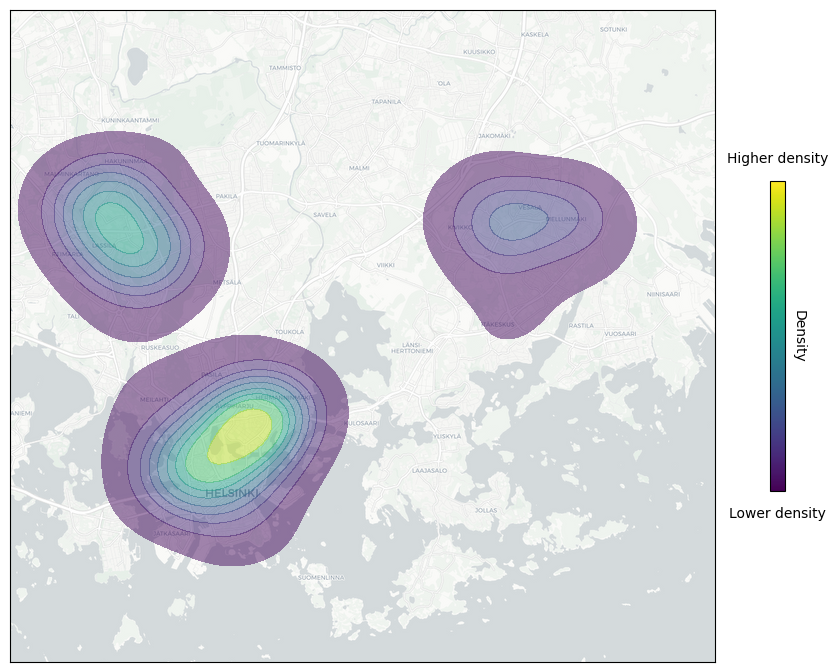

In [36]:
# Define the points from the Helsinki dataset
points = points_in_helsinki

# Create a figure and axis for plotting with a specified size
fig, ax = plt.subplots(figsize=(10, 10))

# Reproject the points to the Web Mercator projection for compatibility with web-based tile services
points = points.to_crs("EPSG:3857")

# Calculate the extent of the points with an additional buffer for margin
extent = tilemapbase.extent_from_frame(points, buffer=5)

# Create a kernel density estimate (KDE) plot of the points
# In newer versions of seaborn, it's important to specify the 'x' and 'y' parameters explicitly
density_plot = sns.kdeplot(
    x=points["geometry"].x,  # X coordinates of points
    y=points["geometry"].y,  # Y coordinates of points
    fill=True,  # Fill the area under the KDE curve; 'fill=True' replaces 'shade=True' in newer seaborn versions
    alpha=0.5,  # Set the transparency of the KDE plot
    cmap="viridis",  # Color map to use for the KDE plot
    zorder=3,  # Drawing order: ensures the KDE plot is drawn above other layers
    ax=ax  # Specify the Matplotlib axes object where the plot should be drawn
)

# Now we use our custom function to draw our map
plot_map(fig, ax, None, None, "KDE_Map", extent, leg = True)


We've previously generated a KDE map that includes all points, without distinguishing between Positive and Negative qualities. To deepen our analysis, we'll next produce two separate KDE maps, one for each quality type. By overlaying these maps with a degree of transparency, we aim to achieve a nuanced visual comparison between the two distributions. Additionally, we'll select a more neutral basemap to ensure that it complements rather than competes with our overlays, allowing for a clearer and more focused visualization.

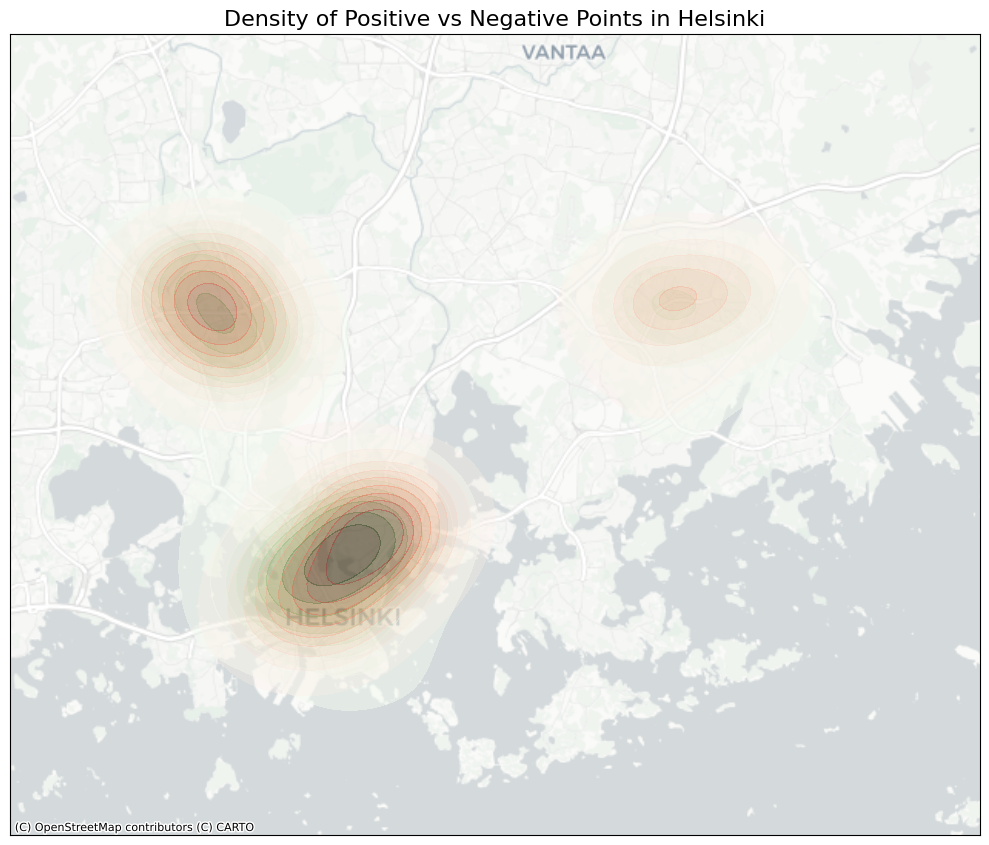

In [27]:
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure your points GeoDataFrame is in the correct CRS (EPSG:3857) for contextily
points = points_in_helsinki.to_crs("EPSG:3857")

# Filter points by category
positive_points = points[points['Quality'] == 'Positive']
negative_points = points[points['Quality'] == 'Negative']

fig, ax = plt.subplots(figsize=(10, 10))

# KDE plot for Positive points
sns.kdeplot(
    x=positive_points["geometry"].x,
    y=positive_points["geometry"].y,
    fill=True,
    alpha=0.5,
    cmap="Greens",
    zorder=3,
    ax=ax,
    label='Positive'
)

# KDE plot for Negative points
sns.kdeplot(
    x=negative_points["geometry"].x,
    y=negative_points["geometry"].y,
    fill=True,
    alpha=0.3,
    cmap="Reds",
    zorder=3,
    ax=ax,
    label='Negative'
)

# Add a simpler basemap with contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zorder=1)

# Customize the plot
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
#ax.set_axis_off()
plt.title('Density of Positive vs Negative Points in Helsinki', fontsize=16)
plt.tight_layout()
fig.savefig('./saved_maps/overlay_pos_neg.png', bbox_inches='tight')
plt.show()
